## Evaluation of Trained C-LSTM Model

In [4]:
import json
import torch
import numpy as np
import sys
import os

from tqdm import tqdm

from rdkit import Chem, RDLogger

In [5]:
from rnn_sampler import ConditionalSmilesRnnSampler
from rnn_utils import load_rnn_model
# from rnn_model import ConditionalSmilesRnn

### Parameters


In [3]:
# model_path = "../models/LSTM_QM9/QM9_small_20epo"
# Path to model file
model_path = "../models/LSTM_QM9/batch_size_20_2"

# Name of model weights file
weights_fname = "LSTM_8_1.151.pt"

# Name of model defition (params) file
definition_fname = "LSTM_8_1.151.json"

### Load Model

In [13]:
sampler = ConditionalSmilesRnnSampler(device = 'cpu', batch_size=64)
model = load_rnn_model(
            model_definition= os.path.join(model_path, definition_fname),
            model_weights = os.path.join(model_path, weights_fname),
            device = 'cpu',
            )

In [29]:
with open(os.path.join(model_path, definition_fname)) as pfile:
    model_params = json.load(pfile)

mpar = model_params['property_names']
print(f'Model Conditioned on Following Props: {mpar}')

Model Conditioned on Following Props: ['LogP']


## Dataset Exploration

In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [217]:
dataset_path = "../data/QM9/"
qmds = pd.read_csv(os.path.join(dataset_path, 'QM9_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['QM9_id', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

Index(['QM9_id', 'SMILES', 'LogP'], dtype='object')
Properties in dataset: ['LogP']


### Target Property Distributions

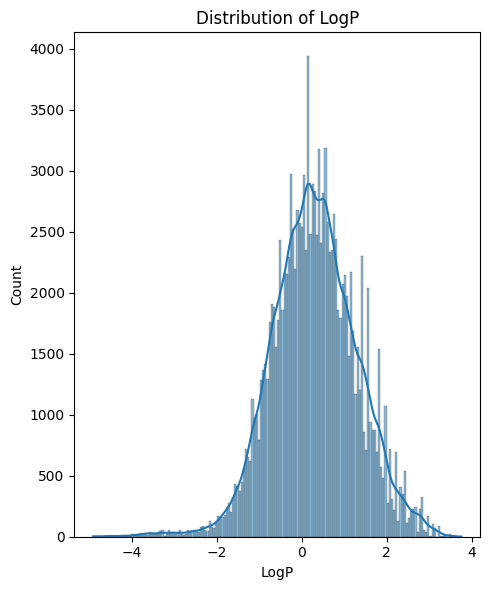

In [218]:
plt.figure(figsize=(len(props) * 5, 6))  # Adjust the size as needed

for i, column in enumerate(props):
    plt.subplot(1, len(props), i + 1)  # (1, total number of columns, current column index)
    sns.histplot(qmds[column], kde=True)  # Using seaborn to plot the distribution with a Kernel Density Estimate
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

## Performance Metrics
Compute validity, novelty, diversity, and property target/achieved correlation for a range of property values

In [96]:
# Property Values with Compound Counterparts within QM9
in_supp_prop_buckets_logp = np.arange(-7, 7, 0.5)

### Validity

In [97]:
def compute_valid_pct(smiles_list):
    '''
    Retrun proportion of SMILES that is valid
    '''
    # Silence RDKit
    RDLogger.DisableLog('rdApp.*')  

    cval = 0
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            cval += 1
    return cval / len(smiles_list)

In [98]:
# Number of molecules per bucket
n_mol_per_bucket = 500

valid_pct = []

for pval in tqdm(in_supp_prop_buckets_logp):
    smiles = sampler.sample(model=model, properties=torch.Tensor([[pval]]), num_to_sample = n_mol_per_bucket, max_seq_len=100)
    valid_pct.append(compute_valid_pct(smiles[0]))

100%|██████████| 28/28 [03:31<00:00,  7.55s/it]


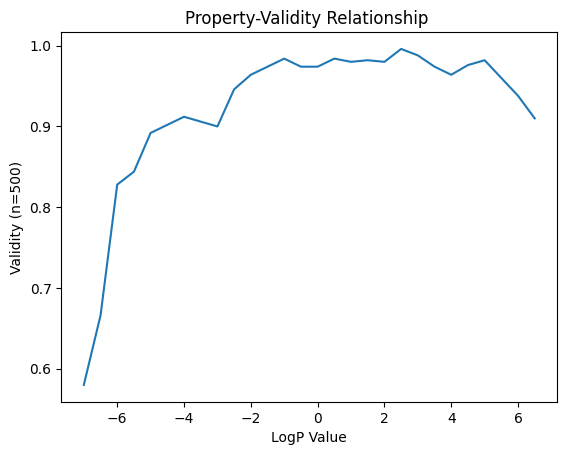

"\nI've ran this a few times and the shape remains consistent.\nThe negative drop off makes sense to me, since it's seen few molecules with such properties in the\ntraining set, the lack of a positive drop off could be explained by some easy 'cheat' such as keep extending\nthe main carbon chain?\n"

In [102]:
data = pd.DataFrame({'X': in_supp_prop_buckets_logp, 'Y': valid_pct})

# Create the line plot
sns.lineplot(x='X', y='Y', data=data)
plt.title('Property-Validity Relationship ')
plt.xlabel('LogP Value')  # Replace with your x-axis label
plt.ylabel('Validity (n=500)')  # Replace with your y-axis label
plt.show()

'''
I've ran this a few times and the shape remains consistent.
The negative drop off makes sense to me, since it's seen few molecules with such properties in the
training set, the lack of a positive drop off could be explained by some easy 'cheat' such as keep extending
the main carbon chain?
TODO: Test this theory?
'''

### Target Property - Generated Property Correlation
- For specific target, visualise distribution of computed properties around the true property

- Generate equally sized samples of molecules for target properties along uniform range of values, compute correlation and plot correlation/target values 

In [146]:
import math

sys.path.append('../utils/')
from property_calculator import PropertyCalculator

pc = PropertyCalculator(['LogP'])

In [124]:
def props_from_smiles(smiles_list, verbose=True):
    '''
    Computes property scores of all valid smiles and returns as list
    '''
    if verbose:
        smiles_list = tqdm(smiles_list)
    props = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            props.append(pc(mol)[0])
    return props

In [128]:
pval = 1
n_to_samp  = 1000

#TODO: Do I need to handle validity? or will it just handle itself?
# Generate Sample
smiles = sampler.sample(model=model, properties=torch.Tensor([[pval]]), num_to_sample = n_to_samp, max_seq_len=100)
props = props_from_smiles(smiles[0])

100%|██████████| 1000/1000 [00:00<00:00, 6102.47it/s]


/tmp/ipykernel_1305958/267088298.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(props, shade=True)


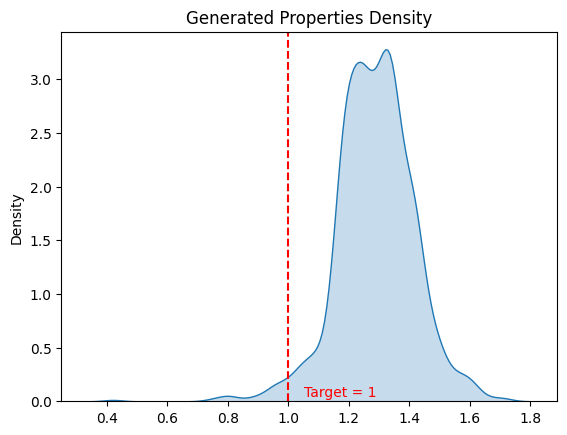

In [129]:
# Plot density and mark desired property
sns.kdeplot(props, shade=True)
plt.title('Generated Properties Density')

plt.axvline(x=pval, color='red', linestyle='--')

plt.text(pval + 0.05, 0.05, f'Target = {pval}', color='red')

plt.show()

In [136]:
## Draw Several of these in parralel to demonstrate the control
target_vals = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
n_to_samp = 1000

props = []
for target in target_vals:
    print(f'Computing smiles for target = {target}')
    smiles = sampler.sample(model=model, properties=torch.Tensor([[target]]), num_to_sample = n_to_samp, max_seq_len=100)
    props.append(props_from_smiles(smiles[0]))

Computing smiles for target = -4


100%|██████████| 1000/1000 [00:00<00:00, 6489.66it/s]


Computing smiles for target = -3


100%|██████████| 1000/1000 [00:00<00:00, 6410.46it/s]


Computing smiles for target = -2


100%|██████████| 1000/1000 [00:00<00:00, 5579.88it/s]


Computing smiles for target = -1


100%|██████████| 1000/1000 [00:00<00:00, 5447.41it/s]


Computing smiles for target = 0


100%|██████████| 1000/1000 [00:00<00:00, 5357.65it/s]


Computing smiles for target = 1


100%|██████████| 1000/1000 [00:00<00:00, 5293.87it/s]


Computing smiles for target = 2


100%|██████████| 1000/1000 [00:00<00:00, 5457.15it/s]


Computing smiles for target = 3


100%|██████████| 1000/1000 [00:00<00:00, 5905.30it/s]


Computing smiles for target = 4


100%|██████████| 1000/1000 [00:00<00:00, 6211.77it/s]


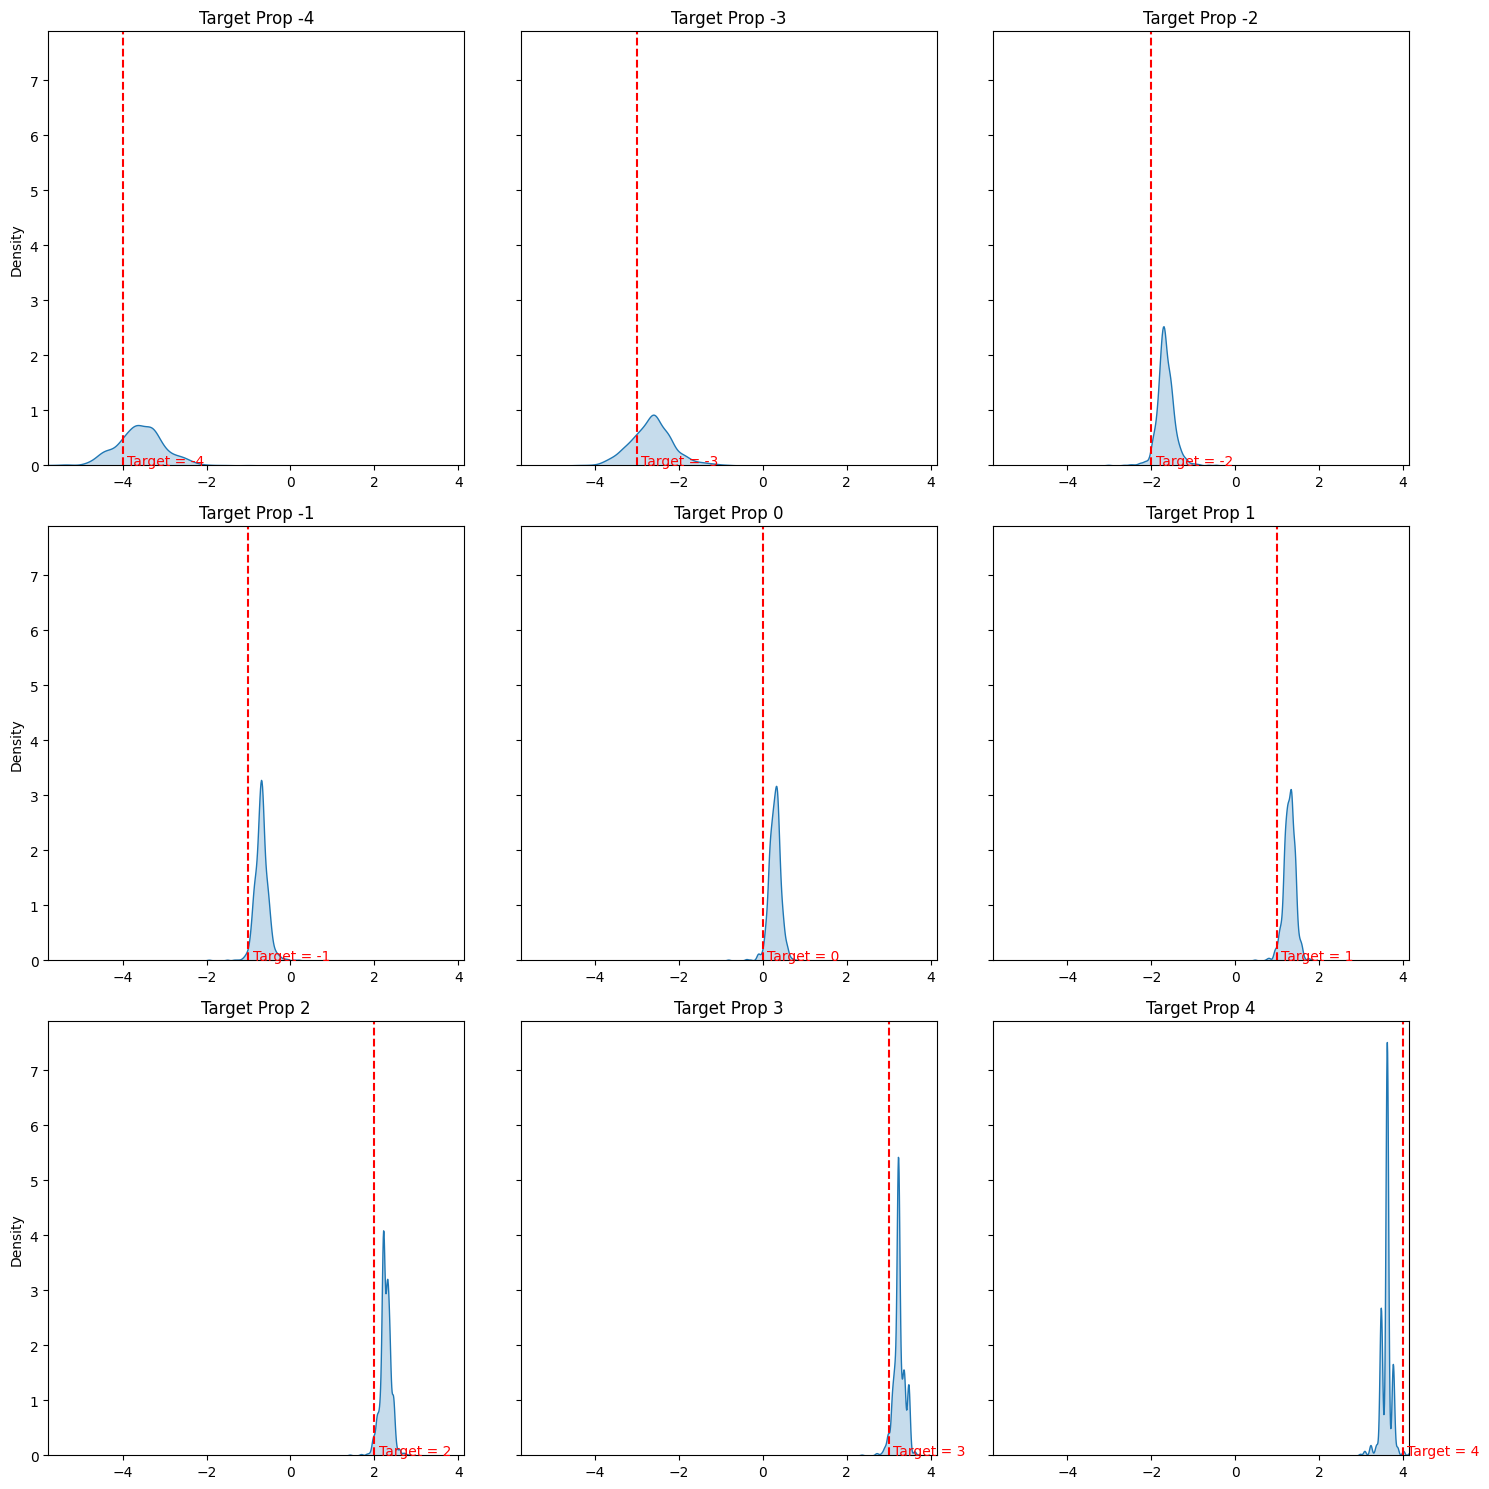

'\nThe control seems to be working very well. \nThe positive bias is interesting. \nTODO: Check if early versions of the model also exhibit this\n'

In [142]:
# Draw on common x axis
all_values = np.concatenate(props)  # Combine all lists into one
x_min = min(all_values)
x_max = max(all_values)
x_lim = (x_min, x_max)

# Place on grid
n_plots = len(props)
n_cols = int(math.ceil(math.sqrt(n_plots)))  # Number of columns
n_rows = int(math.ceil(n_plots / n_cols))  # Number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharey=True)


for i, (data, point) in enumerate(zip(props, target_vals)):
    row = i // n_cols
    col = i % n_cols

    sns.kdeplot(data, fill=True, ax=axes[row, col])
    axes[row, col].axvline(x=point, color='red', linestyle='--')
    axes[row, col].text(point + 0.1, 0.2, f'Target = {point}', color='red', verticalalignment='top')
    axes[row, col].set_title(f'Target Prop {point}')
    axes[row, col].set_xlim(x_lim)

# Hide any unused subplot areas
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

# Adjust layout
plt.tight_layout()
plt.show()

'''
The control seems to be working very well. 
The positive bias is interesting. 
TODO: Check if early versions of the model also exhibit this
'''

In [161]:
# Compute Correlation over Specified Range (uniform target sampling)
data_range = [-3, 3]
n_samples = 2000

# sample targets
targets = np.random.uniform(low=data_range[0], high=data_range[1], size=n_samples)
pairs = []
nvalid = 0
for tar in tqdm(targets):
    smi = sampler.sample(model=model, properties=torch.Tensor([[tar]]), num_to_sample = 1, max_seq_len=100)
    mol = Chem.MolFromSmiles(smi[0][0])
    if mol is not None:
        nvalid += 1
        pval = pc(mol)[0]
        pairs.append([tar, pval])


observations = np.array(pairs).T
corr_matrix = np.corrcoef(observations)
correlation = corr_matrix[0, 1]
validity = nvalid / n_samples

print(f'Correlation: {correlation}')
print(f'Validity: {validity}')

100%|██████████| 2000/2000 [21:10<00:00,  1.57it/s]

Correlation: 0.9932908982792997
Validity: 0.9715


### Diversity
- Uniqueness
- Tanimoto Diversity
- Internal Diversity

In [188]:
from collections import Counter
from rdkit.Chem import AllChem
from rdkit import DataStructs

In [189]:
def compute_diversity_metrics(smiles_list):
    '''
    - Ignores invalid smiles
    - Uses morgan fingerprints
    Return:
    [Pct Unique, Tanimoto Diversity, Internal Diversity]
    '''
    valid_smiles = []
    fingerprints = []

    print('Checking validity and computing fingerprints')
    for smi in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue
        
        valid_smiles.append(smi)
        fingerprints.append(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024))

    # Compute pairwise Tanimoto similarities
    n = len(fingerprints)
    similarities = []
    print('Computing pairwise similarities')
    for i in range(n):
        for j in range(i + 1, n): 
            similarity = DataStructs.FingerprintSimilarity(fingerprints[i], fingerprints[j])
            similarities.append(similarity)

    # Calculate pct Unique
    uniquness = len(set(valid_smiles)) / len(valid_smiles)
    # Calculate Tanimoto Diversity as the average similarity
    tanimoto_diversity = np.mean(similarities)
    # Calculate Internal Diversity as the average dissimilarity
    internal_diversity = np.mean([1 - s for s in similarities])
    return [uniquness, tanimoto_diversity, internal_diversity]



In [169]:
# Generate a large sample of smiles with uniformly sampled targets
# TODO: Would help a lot if there was an unconditional way of sampling ...

data_range = [-3, 3]
n_samples = 2000
targets = np.random.uniform(low=data_range[0], high=data_range[1], size=n_samples)
sample_smiles = []
remove_invalid = True

for tar in tqdm(targets):
    smi = sampler.sample(model=model, properties=torch.Tensor([[tar]]), num_to_sample = 1, max_seq_len=100)
    mol = Chem.MolFromSmiles(smi[0][0])
    if remove_invalid and mol is None:
        continue
    sample_smiles.append(smi[0][0])

100%|██████████| 2000/2000 [21:18<00:00,  1.56it/s]


In [195]:
# Use Counter to count occurrences of each element
# sample_smiles)
uni, tani, inter = compute_diversity_metrics(sample_smiles)
print(f'Pct Unique (uniform props): {uni} ')
print(f'Tanimoto Sim: {tani}')
print(f'Internal Sim (Diversity): {inter}')

Checking validity and computing fingerprints


100%|██████████| 1944/1944 [00:00<00:00, 15650.66it/s]

Computing pairwise similarities


Pct Unique (uniform props): 0.9840534979423868 
Tanimoto Sim: 0.08054273932797663
Internal Sim (Diversity): 0.9194572606720235


In [213]:
target_props = np.arange(-4, 4, 0.5)
t_samp_size = 500

pcts = []
tanis = []
inters = []


for targ in tqdm(target_props):
    targ_samp_smi = sampler.sample(model=model, properties=torch.Tensor([[targ]]), num_to_sample = t_samp_size, max_seq_len=100)[0]
    uni, tani, inter = compute_diversity_metrics(targ_samp_smi)
    pcts.append(uni)
    tanis.append(tani)
    inters.append(inter)

Checking validity and computing fingerprints


100%|██████████| 500/500 [00:00<00:00, 16220.65it/s]

Computing pairwise similarities



100%|██████████| 16/16 [02:02<00:00,  7.64s/it]


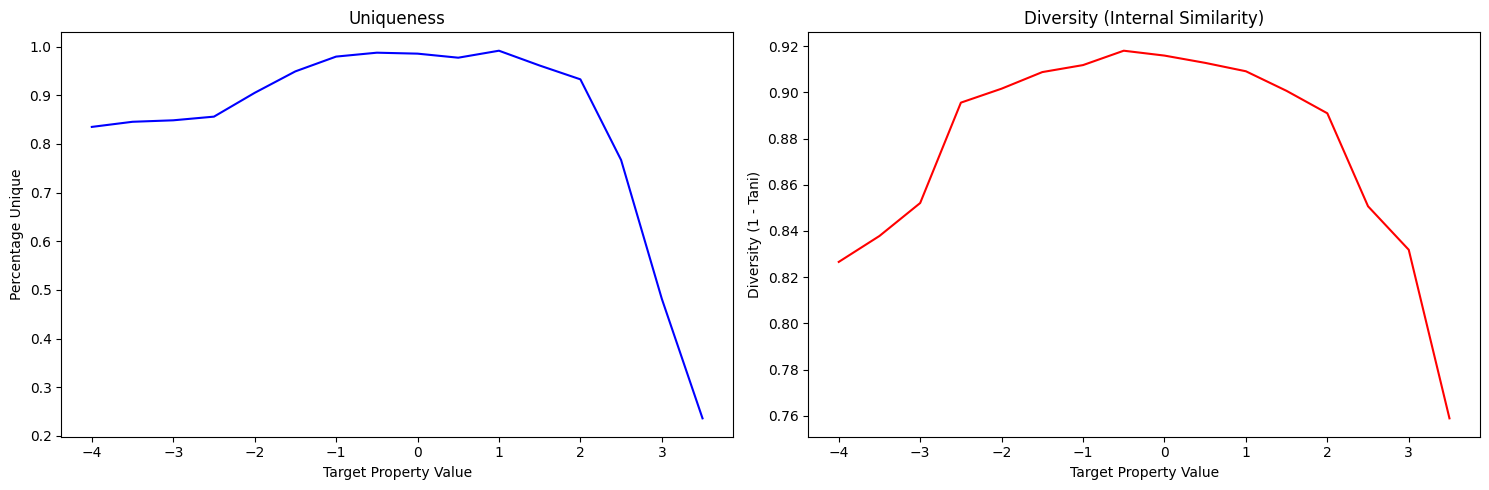

In [214]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Removed sharey=True

sns.lineplot(x=target_props, y=pcts, ax=axs[0], color='blue')
axs[0].set_title('Uniqueness')
axs[0].set_xlabel('Target Property Value')
axs[0].set_ylabel('Percentage Unique')

sns.lineplot(x=target_props, y=inters, ax=axs[1], color='red')
axs[1].set_title('Diversity (Internal Similarity)')
axs[1].set_xlabel('Target Property Value')
axs[1].set_ylabel('Diversity (1 - Tani)')

plt.tight_layout()
plt.show()

### Novelty
Pct generated molecules not found in training set (this is how Guacamol measures it)

In [219]:
# Generate set of smiles with uniformly sampled target properties
data_range = [-4, 4]
n_samples = 2000
targets = np.random.uniform(low=data_range[0], high=data_range[1], size=n_samples)
sample_smiles = []
remove_invalid = True

for tar in tqdm(targets):
    smi = sampler.sample(model=model, properties=torch.Tensor([[tar]]), num_to_sample = 1, max_seq_len=100)
    mol = Chem.MolFromSmiles(smi[0][0])
    if remove_invalid and mol is None:
        continue
    sample_smiles.append(smi[0][0])

100%|██████████| 2000/2000 [20:35<00:00,  1.62it/s]


In [237]:
def compute_novelty(smiles_list, ds_smiles):
    '''
    - Similar to Guacamol def
    Only consider proportion of valid smiles
    Only consider propotion of unique smiles
    '''
    smiles_list = set(smiles_list)
    novel = []
    for smi in smiles_list:
        if smi not in ds_smiles:
            novel.append(smi)
    return len(novel) / len(smiles_list)
            
    

In [239]:
novelty = compute_novelty(sample_smiles, list(qmds['SMILES']))
print(f'Novelty: {novelty}')

Novelty: 0.3626943005181347


In [241]:
# Compute in range
target_props = np.arange(-4, 4, 0.5)
t_samp_size = 500

novelties = []

for targ in tqdm(target_props):
    targ_samp_smi = sampler.sample(model=model, properties=torch.Tensor([[targ]]), num_to_sample = t_samp_size, max_seq_len=100)[0]
    novelties.append(compute_novelty(targ_samp_smi, list(qmds['SMILES'])))
     

100%|██████████| 16/16 [02:19<00:00,  8.69s/it]


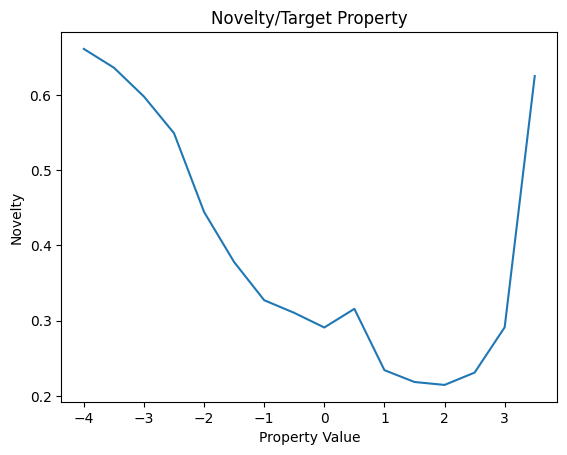

'\nNOTE: for high properties the diversity is very low\n'

In [244]:
# Create the line plot
sns.lineplot(x=target_props, y=novelties)
plt.title('Novelty/Target Property')
plt.xlabel('Property Value')  # Update this label as needed
plt.ylabel('Novelty')  # Update this label as needed
plt.show()

'''
NOTE: for high properties the diversity is very low
'''

### Observations
- As range of property goes left -> validity decreases, as does diversity
- As range of property goes right -> diversity decreases
- It's mostly fine within the set support